# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

(720, 1280, 3)


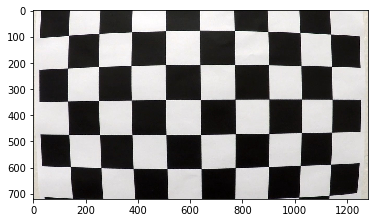

In [640]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./camera_cal/calibration1.jpg')
print(image.shape)
plt.imshow(image)

# Some quick observations
# Image size is consistent
# However, number of intersection x and intersection y is not the same across all the images

In [641]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_corners(fname, nx, ny):
    '''
    Convenience function for testing out chessboard detection
    Returns ret (boolean if result is available), corners coordinates and images
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    return ret, corners, img

def get_object_points(nx, ny):
    '''
    Function to get the object points needed to find the points on the chess board
    Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    '''
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return objp
    
def get_obj_img_points(image_fname_list, nx, ny):
    '''
    Function to obtain the object and image point 
    '''
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Define a default object point
    objp = get_object_points(nx, ny) 
    
    # Step through the list and search for chessboard corners
    for fname in image_fname_list:
        # Find the chessboard corners
        ret, corners, mod_image = get_chessboard_corners(fname, nx, ny)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints
            

In [642]:
# Function testing - all are made to comments as they are only used for testing purposes

# Testing out the functions defined in the above cell
ret, corner, img = get_chessboard_corners('./camera_cal/calibration1.jpg', 9, 5)

True

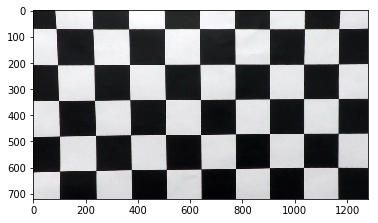

In [643]:
%matplotlib inline

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Get the object points and image points from a set of calibration images
objpoints, imgpoints = get_obj_img_points(images, 9, 6)

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show image
plt.imshow(dst)

# Write the file out into the output folder
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

## Pipeline (single images)

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:




(720, 1280, 3)


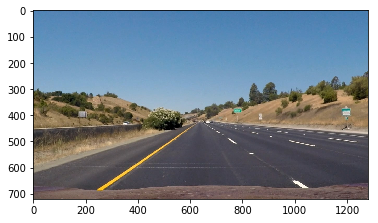

In [644]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Original Image
image = mpimg.imread('./test_images/straight_lines1.jpg')
print(image.shape)
plt.imshow(image)

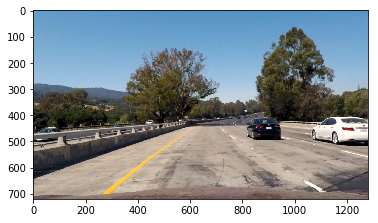

In [167]:
# Undistorted Image
dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(dst)

**Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.**

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)


In [398]:
# Define color threshold functions - Can choose to utilize which one of the color gradients work best

def rgb_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

def hls_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

In [539]:
road_image = mpimg.imread("./test_images/test3.jpg")

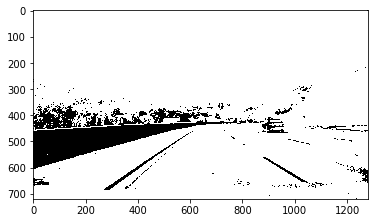

In [540]:
# Testing with just red filter doesn't work
# Test on every single color reveals that none of them work really well because of the shadow. 
# Red may work with some images but it can miserably fail at some of them
rgb_binary = rgb_threshold(road_image, 'r', 'binary', 60, 200)
plt.imshow(rgb_binary, cmap='gray')

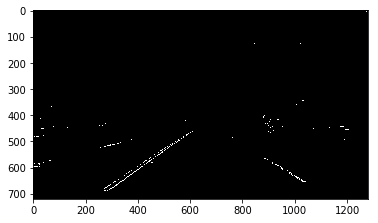

In [541]:
# Testing with just red filter doesn't work
hls_binary = hls_threshold(road_image, 's', 'binary', 120, 200)
plt.imshow(hls_binary, cmap='gray')

In [542]:
# Define a function called sobel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

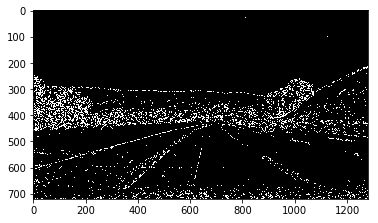

In [543]:
gradx = abs_sobel_thresh(road_image, 'x', 10, 30)
plt.imshow(gradx, cmap='gray')

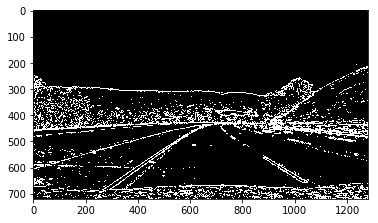

In [544]:
grady = abs_sobel_thresh(road_image, 'y', 10, 200)
plt.imshow(grady, cmap='gray')

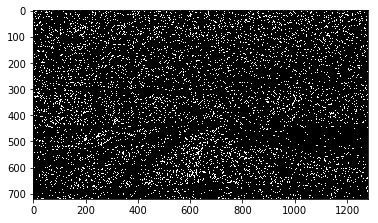

In [545]:
dir_binary = dir_threshold(road_image, 7, (0.1, 0.3))
plt.imshow(dir_binary, cmap='gray')

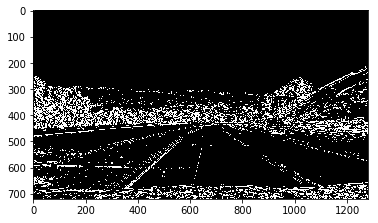

In [546]:
mag_binary = mag_thresh(road_image,5, mag_thresh=(10,30))
plt.imshow(mag_binary, cmap='gray')

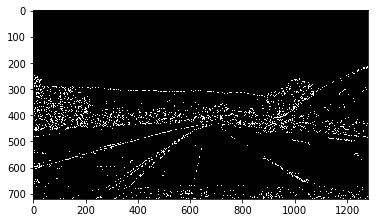

In [547]:
combined = np.zeros_like(rgb_binary)
combined[((gradx == 1) & (grady == 1)) | 
       ((mag_binary == 1) & (dir_binary == 1)) | 
         ((rgb_binary == 0) & (hls_binary == 1))] = 1
# combined[((rgb_binary == 1) | (hls_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

**Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.**

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

In [742]:
road_image = mpimg.imread("./test_images/straight_lines1.jpg")
# Undistort
dst = cv2.undistort(road_image, mtx, dist, None, mtx)
img_size = dst.shape

# Zoomed-out version
src = np.float32(
[[580, 450],
[40, 720],
[1240, 720],
[700, 450]])

# Zoomed-in version
src = np.float32(
[[600, 450],
[200, 720],
[1100, 720],
[680, 450]])

# dst = np.float32(
#     [[0, 0],
#     [0, 720],
#     [1280, 720],
#     [1280, 0]])

dst = np.float32(
    [[(img_size[1] / 4), 0],
    [(img_size[1] / 4), img_size[0]],
    [(img_size[1] * 3 / 4), img_size[0]],
    [(img_size[1] * 3 / 4), 0]])
print(src)
print(dst)

def perspective_wrapper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    perspective_transform = cv2.warpPerspective(img, M, img_size)
    
    return perspective_transform

[[  600.   450.]
 [  200.   720.]
 [ 1100.   720.]
 [  680.   450.]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


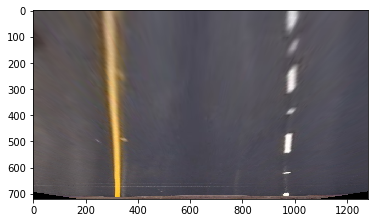

In [744]:
warped_image = perspective_wrapper(road_image, src, dst)
plt.imshow(warped_image)

**Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?**

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

In [ ]:
# Function to get the starting point of the function
def get_start_points(binary_warped):
    '''
    Return the starting point for the left and right lanes
    '''
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_indices(binary_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50):
    '''
    Get left and right lane indices
    '''
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    return left_lane_inds, right_lane_inds

def get_lane_polyfit(left_lane_inds, right_lane_inds):
    '''
    Fit the points generated in indices to form a smooth curve
    '''
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def plot_lane_fit(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    '''
    Plot results form previous lane line calculations
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [ ]:
%matplotlib inline

# Running the image manipulation

# From start to end
# Camera calibration
image =  
dst = cv2.undistort(img, mtx, dist, None, mtx)

**Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.**

I did this in lines # through # in my code in `my_other_file.py`

**Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.**

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]


## Pipeline (video)

Here's a [link to my video result](./project_video.mp4)
TODO: Need to add the correct video link

## Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
